<a href="https://www.kaggle.com/code/omaraboelnaga/news-classification?scriptVersionId=199652364" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import spacy
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report , confusion_matrix,mean_absolute_error
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb

In [2]:
df = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/Fake.csv')
df

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
...,...,...,...,...
23476,McPain: John McCain Furious That Iran Treated ...,21st Century Wire says As 21WIRE reported earl...,Middle-east,"January 16, 2016"
23477,JUSTICE? Yahoo Settles E-mail Privacy Class-ac...,21st Century Wire says It s a familiar theme. ...,Middle-east,"January 16, 2016"
23478,Sunnistan: US and Allied ‘Safe Zone’ Plan to T...,Patrick Henningsen 21st Century WireRemember ...,Middle-east,"January 15, 2016"
23479,How to Blow $700 Million: Al Jazeera America F...,21st Century Wire says Al Jazeera America will...,Middle-east,"January 14, 2016"


In [3]:
df2 = pd.read_csv('/kaggle/input/fake-and-real-news-dataset/True.csv')
df2

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [4]:
df['Fake'] = 1
df2['Fake'] = 0

In [5]:
df2.subject.value_counts()

subject
politicsNews    11272
worldnews       10145
Name: count, dtype: int64

In [6]:
df.subject.value_counts()

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
Name: count, dtype: int64

In [7]:
df3 =  pd.concat([df,df2], axis = 0)

In [8]:
df3 = df3.drop(['date','subject' ], axis = 1)

In [9]:
df3

,title,text,Fake
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,1
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,1
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",1
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",1
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,1
...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,0
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",0
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,0
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,0


In [10]:
def preprocess(text):
    nlp = spacy.load('en_core_web_sm')
    doc = nlp(text)
    filtered = []
    for i in doc:
        if((i.is_stop or i.is_punct)):
            continue
        else:
            filtered.append(i.stem_)
    return ' '.join(filtered)

In [11]:
print(df['title'][:10])

0     Donald Trump Sends Out Embarrassing New Year’...
1     Drunk Bragging Trump Staffer Started Russian ...
2     Sheriff David Clarke Becomes An Internet Joke...
3     Trump Is So Obsessed He Even Has Obama’s Name...
4     Pope Francis Just Called Out Donald Trump Dur...
5     Racist Alabama Cops Brutalize Black Boy While...
6     Fresh Off The Golf Course, Trump Lashes Out A...
7     Trump Said Some INSANELY Racist Stuff Inside ...
8     Former CIA Director Slams Trump Over UN Bully...
9     WATCH: Brand-New Pro-Trump Ad Features So Muc...
Name: title, dtype: object


In [12]:
x_train,x_test,y_train,y_test = train_test_split(
df3.iloc[:, 0],
df3['Fake'],
random_state =  42,
train_size = 0.8,
stratify = df3.Fake
)

Text(0.5, 1.0, 'Confusion Matrix using Naive Bayes algorithm')

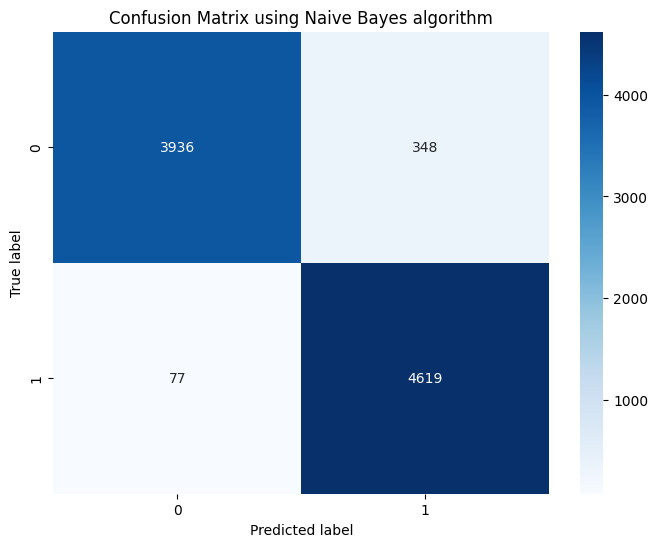

In [13]:
clf = Pipeline([
    ('vectorizer_bow',  CountVectorizer(ngram_range = (1,3))),
    ('Multi NB' , MultinomialNB())
    
])
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True , fmt = 'g' , cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix using Naive Bayes algorithm')

In [14]:
print(clf.score(x_test,y_test))

0.9526726057906458


Text(0.5, 1.0, 'Confusion Matrix using XGboost algorithm')

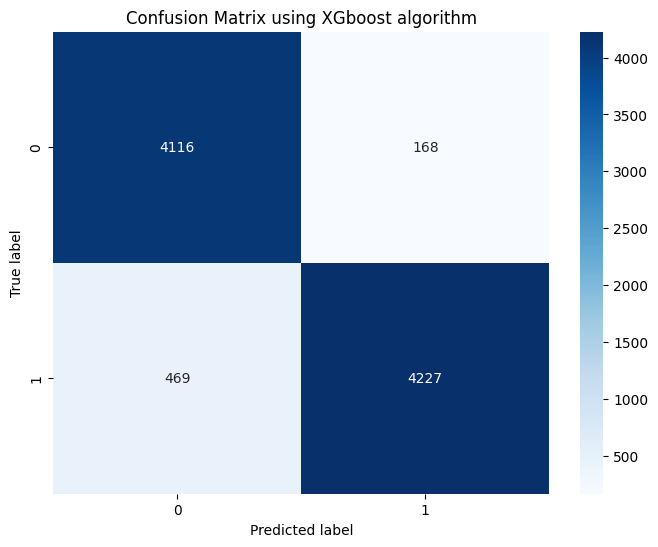

In [15]:
clf = Pipeline([
    ('vectorizer_bow',  CountVectorizer(ngram_range = (1,3))),
    ('XGBoost Classifier' , xgb.XGBClassifier())
    
])
clf.fit(x_train,y_train)
y_pred = clf.predict(x_test)
plt.figure(figsize=(8, 6))
sns.heatmap(confusion_matrix(y_test,y_pred), annot = True , fmt = 'g' , cmap = 'Blues')
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix using XGboost algorithm')

In [16]:
print(clf.score(x_test,y_test))

0.929064587973274
